<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/TorchClassfiyTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#손글씨 분류 파이토치 실습
#불러오기
import torch #파이토치 라이브러리 불러오기
import torch.nn as nn #딥러닝 네트워크의 기본 구성요소를 포함한 torch.nn패키지를 가져와서 nn이름으로 선언
import torch.nn.functional as F  #딥러닝에 자주 사용되는 함수가 포함 된 module인 torch.nn.funtional을 가져온다. F로 선언
import torch.optim as optim #가중치 추정에 필요한 알고리즘이 포함 된 모듈 torch.optim을 가져온다. optim으로 선언
from torchvision import datasets, transforms #기본적인 딥러닝 데이터셋이 포함 모델 구조, 이미지 변환 기술을 포함한 torchvision모듈이다.
#torchvsion 모듈에서 datasets와 transform 함수만 가져온다.
from matplotlib import pyplot as plt


In [3]:
#분석 환경 설정하기
is_cuda = torch.cuda.is_available()
device = torch.device('cuda'if is_cuda else 'cpu')#GPU(쿠다)를 사용할 수 있으면 true이고 아니면 false로 cpu를 사용한다.

print('Current cuda device is', device)


Current cuda device is cuda


In [4]:
#HyperParameter 지정하기
batch_size = 50 #한 번에 학습 할 이미지의 양
epoch_num = 15 #총 학습 횟수
learning_rate = 0.0001 #가중치 업데이트(학습율) 정도

In [5]:
#Mnist 데이터셋 불러오기.
train_data = datasets.MNIST(root = './data', train = True, download=True, transform = transforms.ToTensor())
#root는 Mnistdata를 저장할 공간이다. ./data는 현재위치의 폴더이다.
#download는 데이터셋이 아직 저장 안 되어 있다면 True로 설정해서 불러온다.
test_data = datasets.MNIST(root = './data', train=False, transform = transforms.ToTensor())
#transform을 통해서 입력과 Mnist데이터를 입력과 동시에 전처리 할 수 있는 옵션이다. 파이토치는 입력데이터로 tensor로 사용하므로 이미지를 tensor로 변형하여 처리하는 transforms.ToTensor()를 사용한다. 

print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))


31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



102.8%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



112.7%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

number of training data :  60000
number of test data :  10000


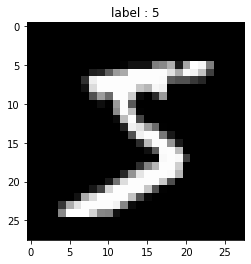

In [6]:
#Mnist data 확인하기

image, label = train_data[0] #image와 label에 첫 번째 학습 데이터의 입력데이터와 정답(라벨)을 제공한다.
#Mnist의 이미지는  3차원 tesnor로 [channel,width,height]=[1,28,28]이다.
plt.imshow(image.squeeze().numpy(),cmap='gray')
#3차원 이미지를 2차원 텐서[28.28]로 줄이는 image.squeeze().numpy()함수를 사용한다. matplotlib의 pyplot에 포함 되어 있다.
plt.title('label : %s'%label)
plt.show()


In [7]:
#미니 배치 구성하기
train_loader = torch.utils.data.DataLoader(dataset = train_data, #dataset 파라미터로 미니 배치로 구성할 데이터로 초기화 
                                           batch_size = batch_size, #미니 배치의 사이즈를 50개로 결정
                                           shuffle = True) #딥러닝이므로 시계열이 아닌 이상 순서를 섞음으로써 훈련 시킴.
test_loader = torch.utils.data.DataLoader(dataset= test_data,
                                          batch_size = batch_size,
                                          shuffle = True)

first_batch = next(iter(train_loader))
print('{:15s} | {:25s} | {}'.format('name','type','size')) #60000개의 훈련데이터를 50개씩 쪼갰으므로 총 1200개의 배치가 생성 됨.
print('{:15s} | {:25s} | {}'.format('Num of batch','',len(train_loader))) 
print('{:15s} | {:25s} | {}'.format('first_batch',str(type(first_batch)),len(first_batch))) # 
print('{:15s} | {:25s} | {}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape)) #미니배치의 첫 번째 요소의 차원은 4차원 텐서로 [50,1,28,28]이다. [batch_size, channel, width, height]이다.
print('{:15s} | {:25s} | {}'.format('first_batch[1]',str(first_batch[1]),first_batch[1].shape)) #미니배치의 두 번째 요소에는 정답이 저장되어 있다.


name            | type                      | size
Num of batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | tensor([8, 8, 7, 5, 4, 6, 7, 8, 9, 6, 3, 9, 5, 0, 4, 3, 5, 3, 0, 0, 3, 7, 5, 0,
        0, 2, 1, 5, 6, 9, 1, 4, 1, 7, 0, 5, 3, 7, 4, 2, 8, 6, 4, 0, 8, 1, 0, 1,
        3, 4]) | torch.Size([50])
